In [12]:
import tqdm
import torch
import numpy as np
import pandas as pd
from torch import nn, einsum
import seaborn as sns
import scipy.io as sio
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from einops import rearrange, repeat
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# !nvidia-smi
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


# Small data

In [13]:
import numpy as np

# load data
eeg = np.load('sliced/slices.npy')
# normalize data use minmaxscaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-10, 10))
eeg = scaler.fit_transform(eeg.reshape(-1, 23)).reshape(eeg.shape)
print('min: ', np.min(eeg))
print('max: ', np.max(eeg))

# print(eeg.shape)  # expected to be (54, 23, 10, 256)

# create list to store the pairs
pair_list = []
label_list = []

# loop over patients
for patient in eeg:
    patient_pairs = []
    patient_labels = []
    # loop over segments within each patient
    for i in range(9):  # 9 pairs for 10 segments
        # concatenate segments along the time axis
        pair = np.concatenate([patient[:, i, :], patient[:, i+1, :]], axis=1)
        patient_pairs.append(pair)
        patient_labels.append(i)
    pair_list.append(patient_pairs)
    label_list.append(patient_labels)

# convert lists to numpy arrays
pair_array = np.array(pair_list).reshape(54*9, 23, 512)
pair_array = np.transpose(pair_array, (0, 2, 1))
label_array = np.array(label_list).reshape(54*9, 1)

print(pair_array.shape)  # should be (54, 9, 23, 512)
print(label_array.shape)  # should be (54, 9)


min:  -10.0
max:  10.000002
(486, 512, 23)
(486, 1)


In [14]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data,label ,transform = None):
        self.transform = transform

        self.data = data
        self.label = label
        self.datanum = len(data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data = torch.tensor(self.data[idx]).float()
        out_label = torch.tensor(self.label[idx])
        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train, test, train_label, test_label = train_test_split(pair_array, np.array(label_array),test_size = 0.1,stratify=np.array(label_array), random_state = 0)
print('train data:',len(train),len(train_label))
print('test data:',len(test),len(test_label))

train_data_set = Mydatasets(data=train,label=train_label)
test_data_set = Mydatasets(data=test,label=test_label)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 16, shuffle=True, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 16, shuffle=False, drop_last=True)

train data: 437 437
test data: 49 49


# GRU GRU

In [15]:
# GRU
class CPC(nn.Module):
    def __init__ (self, input_layer,hidden_layer, n_layer, num_class,group, time_step):
        super().__init__()
        
        self.time_step = time_step # k  ___learn___{   len=time_step   }
        # input size: (Bch, len, chnl)
        # nn.GRU: (in=chnl, out=>chnl2, GRU layers)
        self.gru_first = nn.GRU(23, 128, 3, batch_first = True)#(bs, 256, 22) -> (bs, 256, 128)
   
        self.gru = nn.GRU(input_layer,hidden_layer,n_layer,batch_first = True)
        
        self.dec = nn.ModuleList([nn.Linear(hidden_layer,128) for i in range(time_step)])# k=T, could!=, 
        
        self.mlp_head = nn.Linear(hidden_layer,num_class)
        
        self.softmax = nn.Softmax(dim=1)
        
        self.lsoftmax = nn.LogSoftmax(dim=1) # loss func 


    def forward(self,x):
        batch = x.shape[0] 
                
        t_samples = 255 # where to start: ___learn___{ }____pred____

        z,__ = self.gru_first(x) # z:(bs, 256, 128)
        
        nce = 0
        
        encoder_sample = torch.empty((self.time_step,batch,128)).float() # Z_{t+k}; ()
        
        for i in np.arange(1,self.time_step+1):
            encoder_sample[i-1] = z[:,t_samples+i,:].view(batch,128) #from start to start+k
        
        forward_seq = z[:,:t_samples+1,:] # Z_{t}, {  forward_seq  }_____pred______
        
        output,hidden = self.gru(forward_seq) # decrease dim, (bs, 256-128, 128) --> (bs, 256-128, 64)
        c_t = output[:,t_samples,:].view(batch,64)# at T time, (bs, 128th, 64) --> (bs, 64)
        
        pred = torch.empty((self.time_step,batch,128)).float() # W_{k}C_{t}, empty(128, bs, 128)
        for i in np.arange(0,self.time_step): # do time_step=128 times linear
            linear = self.dec[i]
            pred[i] = linear(c_t) # (bs, 64)--> (bs, 128)
        for i in np.arange(0,self.time_step):
            total = torch.mm(encoder_sample[i], torch.transpose(pred[i],0,1)) # positive samples
            correct = torch.sum(torch.eq(torch.argmax(self.softmax(total),dim=0),torch.arange(0,batch))) # pred, label
            nce += torch.sum(torch.diag(self.lsoftmax(total)))
        nce /= -1.*batch*self.time_step
        acc = 1.*correct.item()/batch
        
        out = self.mlp_head(output[:,-1,:]) #for cls, ct or zt is ok.
        return acc,nce,out
        

In [16]:
DEVICE = torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
CPC_model = CPC(
    input_layer=128, # LSTM input
    hidden_layer=64, # LSTM dim
    n_layer=1, # LSTM layers
    num_class=9, 
    group=5, # wave band, no use
    time_step= 256, # k, how long future you will predict
).to(DEVICE)

print(DEVICE)
total = sum(p.numel() for p in CPC_model.parameters())
print(CPC_model)
print(total)

optimizer = torch.optim.AdamW(CPC_model.parameters(), lr = 0.01)

cuda:0
CPC(
  (gru_first): GRU(23, 128, num_layers=3, batch_first=True)
  (gru): GRU(128, 64, batch_first=True)
  (dec): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=64, out_features=128, bias=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Linear(in_features=64, out_features=128, bias=True)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): Linear(in_features=64, out_features=128, bias=True)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): Linear(in_features=64, out_features=128, bias=True)
    (10): Linear(in_features=64, out_features=128, bias=True)
    (11): Linear(in_features=64, out_features=128, bias=True)
    (12): Linear(in_features=64, out_features=128, bias=True)
    (13): Linear(in_features=64, out_features=128, bias=True)
    (14):

# Classification

In [17]:
import torch.nn as nn
import torch
import tqdm

# assuming that you have already defined CPC_model, DEVICE, and optimizer
EPOCH = 30
train_times = 0

loss_func = nn.CrossEntropyLoss()

loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    for  _, (inputs, labels) in enumerate(train_dataloader, 0):
        # print(f'Batch: {i}, Inputs Size: {inputs.size()}, Labels Size: {labels.size()}')
        
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)   # casting to long
        labels = labels.to(DEVICE)

        acc, nce_loss, outputs = CPC_model(inputs)

        clsfy_loss = loss_func(outputs, labels.squeeze()) # .squeeze()

        total_loss = clsfy_loss + nce_loss

        # Backpropagate the loss
        total_loss.backward()

        # Update the weights
        optimizer.step()

        # Print statistics
        running_loss += total_loss.item()
        if count % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, count + 1, running_loss / 100))
            running_loss = 0.0

        count += 1

    # evaluation phase
    CPC_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():  # Disable gradient calculation
        for _, (inputs, labels) in enumerate(test_dataloader, 0):
            inputs = inputs.to(DEVICE)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(DEVICE)

            acc, nce_loss, outputs = CPC_model(inputs)
            clsfy_loss = loss_func(outputs, labels.squeeze())

            total_loss = clsfy_loss + nce_loss
            val_loss += total_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

        val_loss /= len(test_dataloader)
        val_accuracy = correct_preds / total_preds

        print('Validation Loss: {:.3f}, Accuracy: {:.3f}'.format(val_loss, val_accuracy))

    CPC_model.train()  # Set the model back to training mode

print('Finished Training')


  3%|▎         | 1/30 [00:22<10:49, 22.41s/it]

Validation Loss: 4.186, Accuracy: 2.250


  7%|▋         | 2/30 [00:44<10:25, 22.33s/it]

Validation Loss: 1.748, Accuracy: 2.688


 10%|█         | 3/30 [01:06<09:59, 22.22s/it]

Validation Loss: 1.318, Accuracy: 2.667


 13%|█▎        | 4/30 [01:28<09:32, 22.00s/it]

Validation Loss: 2.216, Accuracy: 2.688


 17%|█▋        | 5/30 [01:49<09:06, 21.84s/it]

Validation Loss: 0.918, Accuracy: 2.708


 20%|██        | 6/30 [02:11<08:42, 21.79s/it]

Validation Loss: 0.889, Accuracy: 2.708


 23%|██▎       | 7/30 [02:33<08:21, 21.79s/it]

Validation Loss: 0.884, Accuracy: 2.708


 27%|██▋       | 8/30 [02:55<07:58, 21.77s/it]

Validation Loss: 0.882, Accuracy: 2.708


 30%|███       | 9/30 [03:17<07:38, 21.82s/it]

Validation Loss: 0.880, Accuracy: 2.708


 33%|███▎      | 10/30 [03:39<07:17, 21.86s/it]

Validation Loss: 0.880, Accuracy: 2.708


 37%|███▋      | 11/30 [04:00<06:55, 21.84s/it]

Validation Loss: 0.879, Accuracy: 2.708


 40%|████      | 12/30 [04:22<06:33, 21.85s/it]

Validation Loss: 0.879, Accuracy: 2.708


 43%|████▎     | 13/30 [04:45<06:13, 21.98s/it]

Validation Loss: 0.878, Accuracy: 2.708


 47%|████▋     | 14/30 [05:07<05:52, 22.06s/it]

Validation Loss: 0.878, Accuracy: 2.708


 50%|█████     | 15/30 [05:29<05:31, 22.07s/it]

Validation Loss: 0.876, Accuracy: 2.708


 53%|█████▎    | 16/30 [05:51<05:08, 22.05s/it]

Validation Loss: 5.191, Accuracy: 1.667


 57%|█████▋    | 17/30 [06:13<04:46, 22.04s/it]

Validation Loss: 5.063, Accuracy: 1.667


 60%|██████    | 18/30 [06:35<04:25, 22.10s/it]

Validation Loss: 5.289, Accuracy: 1.667


 63%|██████▎   | 19/30 [06:57<04:02, 22.04s/it]

Validation Loss: 5.002, Accuracy: 2.000


 67%|██████▋   | 20/30 [07:19<03:39, 21.94s/it]

Validation Loss: 5.264, Accuracy: 1.667


 70%|███████   | 21/30 [07:40<03:16, 21.88s/it]

Validation Loss: 5.172, Accuracy: 1.667


 73%|███████▎  | 22/30 [08:03<02:55, 21.93s/it]

Validation Loss: 5.029, Accuracy: 1.667


 77%|███████▋  | 23/30 [08:24<02:32, 21.84s/it]

Validation Loss: 5.185, Accuracy: 2.000


 80%|████████  | 24/30 [08:46<02:11, 21.90s/it]

Validation Loss: 5.047, Accuracy: 1.667


 83%|████████▎ | 25/30 [09:08<01:49, 21.97s/it]

Validation Loss: 5.062, Accuracy: 1.667


 87%|████████▋ | 26/30 [09:31<01:28, 22.12s/it]

Validation Loss: 5.093, Accuracy: 1.667


 90%|█████████ | 27/30 [09:53<01:06, 22.01s/it]

Validation Loss: 5.020, Accuracy: 1.667


 93%|█████████▎| 28/30 [10:15<00:44, 22.02s/it]

Validation Loss: 5.097, Accuracy: 1.667


 97%|█████████▋| 29/30 [10:36<00:21, 21.98s/it]

Validation Loss: 5.014, Accuracy: 1.667


100%|██████████| 30/30 [10:58<00:00, 21.96s/it]

Validation Loss: 5.017, Accuracy: 1.667
Finished Training


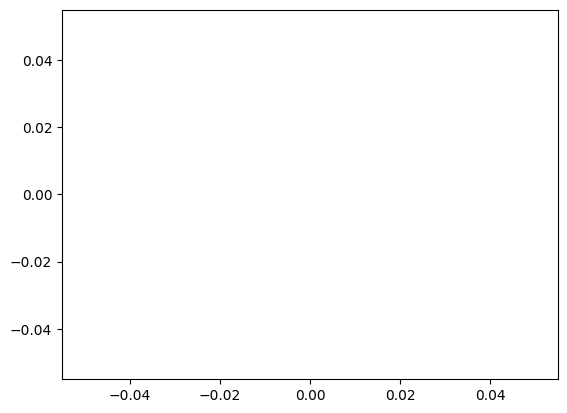

In [18]:
plt.plot(loss_list[1:])

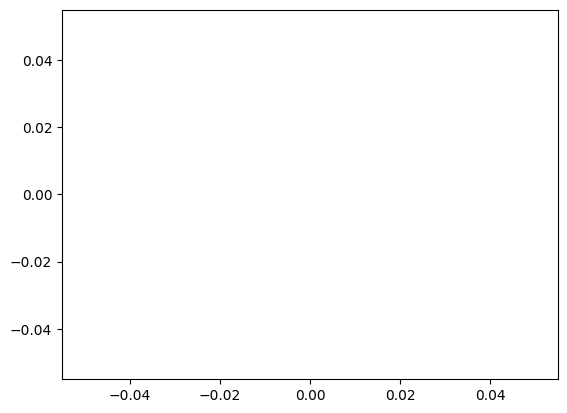

In [19]:
plt.plot(ac_list[1:])

# SELF learning

In [20]:
EPOCH = 30
train_times = 0

loss_list=[]
val_loss_list=[]
ac_list=[]

for epoch in tqdm.tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    for  _, (inputs, labels) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)

        labels = labels.to(DEVICE)

        acc,nce_loss,_ = CPC_model(inputs)

        losses = nce_loss
        losses.backward()
        optimizer.step() 
        running_loss += losses.item()
        count = count+1
    loss_loss = running_loss/count
    loss_list.append(loss_loss)
    print('epoch',epoch+1,':finished')
    print('train_loss:',loss_loss)

  3%|▎         | 1/30 [00:21<10:37, 21.97s/it]

epoch 1 :finished
train_loss: 2.7726277068809226


  7%|▋         | 2/30 [00:43<10:09, 21.78s/it]

epoch 2 :finished
train_loss: 2.772595591015286


 10%|█         | 3/30 [01:05<09:49, 21.85s/it]

epoch 3 :finished
train_loss: 2.772577921549479


 13%|█▎        | 4/30 [01:27<09:24, 21.69s/it]

epoch 4 :finished
train_loss: 2.7725629806518555


 17%|█▋        | 5/30 [01:48<09:01, 21.65s/it]

epoch 5 :finished
train_loss: 2.772538759090282


 20%|██        | 6/30 [02:10<08:40, 21.69s/it]

epoch 6 :finished
train_loss: 2.7724891591955116


 23%|██▎       | 7/30 [02:31<08:18, 21.66s/it]

epoch 7 :finished
train_loss: 2.7723347257684776


 27%|██▋       | 8/30 [02:53<07:58, 21.75s/it]

epoch 8 :finished
train_loss: 2.7686413394080267


 30%|███       | 9/30 [03:16<07:44, 22.12s/it]

epoch 9 :finished
train_loss: 2.7623581091562905


 33%|███▎      | 10/30 [03:39<07:28, 22.40s/it]

epoch 10 :finished
train_loss: 2.7723663912879095


 37%|███▋      | 11/30 [04:02<07:05, 22.39s/it]

epoch 11 :finished
train_loss: 2.7819307733465126


 40%|████      | 12/30 [04:25<06:48, 22.68s/it]

epoch 12 :finished
train_loss: 2.77259150257817


 43%|████▎     | 13/30 [04:48<06:27, 22.80s/it]

epoch 13 :finished
train_loss: 2.7725897983268455


 47%|████▋     | 14/30 [05:11<06:03, 22.70s/it]

epoch 14 :finished
train_loss: 2.772589400962547


 50%|█████     | 15/30 [05:33<05:39, 22.66s/it]

epoch 15 :finished
train_loss: 2.772589021258884


 53%|█████▎    | 16/30 [05:55<05:15, 22.52s/it]

epoch 16 :finished
train_loss: 2.7725890477498374


 57%|█████▋    | 17/30 [06:17<04:51, 22.40s/it]

epoch 17 :finished
train_loss: 2.7725888976344355


 60%|██████    | 18/30 [06:40<04:28, 22.35s/it]

epoch 18 :finished
train_loss: 2.7725886503855386


 63%|██████▎   | 19/30 [07:02<04:06, 22.37s/it]

epoch 19 :finished
train_loss: 2.7725882795121937


 67%|██████▋   | 20/30 [07:24<03:42, 22.29s/it]

epoch 20 :finished
train_loss: 2.772588129396792


 70%|███████   | 21/30 [07:46<03:19, 22.14s/it]

epoch 21 :finished
train_loss: 2.7725879351298013


 73%|███████▎  | 22/30 [08:08<02:56, 22.05s/it]

epoch 22 :finished
train_loss: 2.772587952790437


 77%|███████▋  | 23/30 [08:30<02:34, 22.06s/it]

epoch 23 :finished
train_loss: 2.7725877850144


 80%|████████  | 24/30 [08:52<02:12, 22.07s/it]

epoch 24 :finished
train_loss: 2.772587670220269


 83%|████████▎ | 25/30 [09:14<01:49, 21.98s/it]

epoch 25 :finished
train_loss: 2.7725876525596336


 87%|████████▋ | 26/30 [09:36<01:27, 21.99s/it]

epoch 26 :finished
train_loss: 2.772587458292643


 90%|█████████ | 27/30 [09:58<01:06, 22.11s/it]

epoch 27 :finished
train_loss: 2.7725873434985124


 90%|█████████ | 27/30 [10:12<01:08, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(loss_list[1:])
print(acc)

In [ ]:
plt.plot(loss_list[1:])
print(acc)